Data telah berhasil dibersihkan, berikut diagramnya


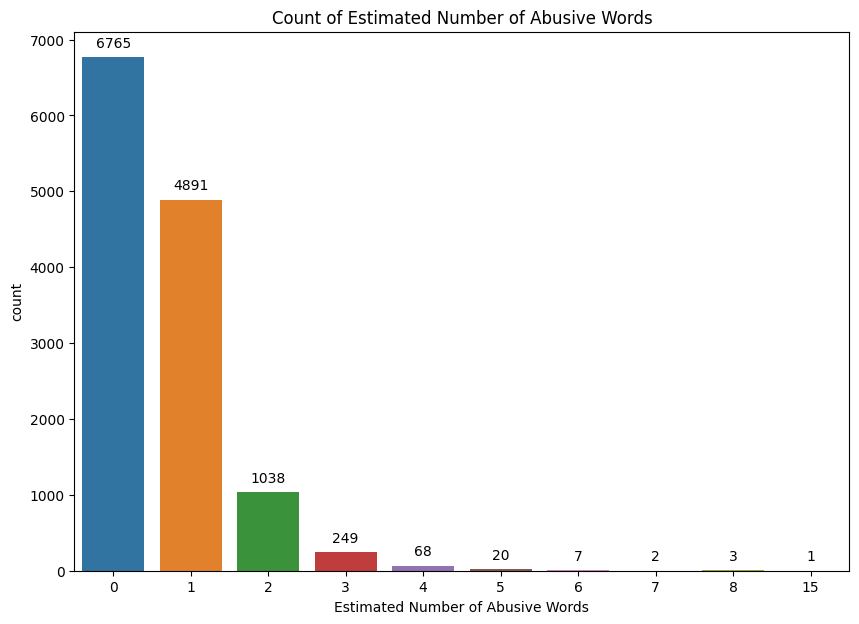

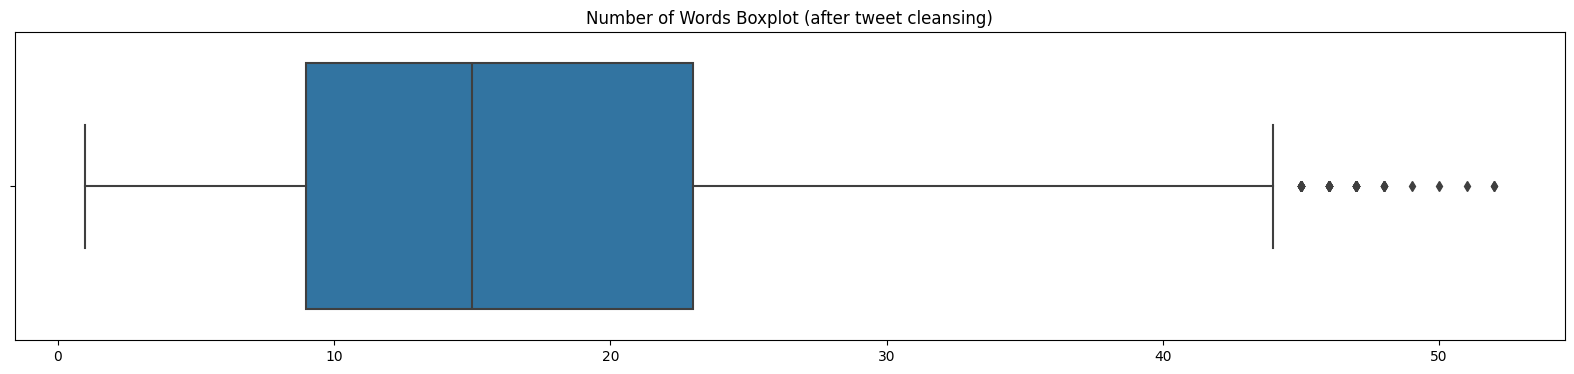

In [6]:
# IMPORT TOOLS
import sqlite3
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# IMPORT DATA .csv
df_alay = pd.read_csv(r"C:\Users\ANOM\Documents\data science\new_kamusalay.csv", encoding='latin-1')
df_alay.columns = ["Old_Word", "New_Word"]
df_abusive = pd.read_csv(r"C:\Users\ANOM\Documents\data science\abusive.csv")

# IMPORT DATA CSV YANG AKAN DIBERSIHKAN
df_data = pd.read_csv(r"C:\Users\ANOM\Documents\data science\data.csv", encoding='latin-1')

# MENGHILANGKAN DUPLIKAT DATA
df_data.drop_duplicates(inplace=True)
    
# MENAMBAHKAN KOLOM JUMLAH KARAKTER (no_char) DAN JUMLAH KATA (no_words) DARI MASING-MASING TWEET
df_data['no_char'] = df_data['Tweet'].apply(len)
df_data['no_words'] = df_data['Tweet'].apply(lambda x: len(x.split()))
    
# MEMBERSIHKAN DATA DARI KARAKTER NON ALPANUMERIK, DAN HASILNYA DI-INPUT DI KOLOM BARU (cleaned_tweet)
def tweet_cleansing(x):
    tweet = x
    cleaned_tweet = re.sub(r'[^a-zA-Z0-9 ]','',tweet).strip()
    return cleaned_tweet
    
df_data['cleaned_tweet'] = df_data['Tweet'].apply(lambda x: tweet_cleansing(x))
    
# MENGHITUNG KEMBALI JUMLAH KARAKTER DAN JUMLAH KATA DARI HASIL DATA YANG TELAH DIBERSIHKAN, LALU DI-INPUT DI KOLOM BARU (no_char_2 dan no_words_2)
df_data['no_char_2'] = df_data['cleaned_tweet'].apply(len)
df_data['no_words_2'] = df_data['cleaned_tweet'].apply(lambda x: len(x.split()))
    
# MENGECEK DAN MENGHITUNG KATA-KATA ABUSIVE YANG TERDAPAT PADA DATA TWEET YANG TELAH DIBERSIHKAN. HASILNYA DI-INPUT KE KOLOM BARU (estimated_no_abs_words)
def count_abusive(x):
    cleaned_tweet = x
    matched_list = []
    for i in range(len(df_abusive)):
        for j in x.split():
            word = df_abusive['ABUSIVE'].iloc[i]
            if word==j.lower():
                matched_list.append(word)
    return len(matched_list)
    
df_data['estimated_no_abs_words'] = df_data['cleaned_tweet'].apply(lambda x: count_abusive(x))
    
# MEMBUAT/MENGHUBUNGKAN DATABASE BARU, LALU MEMBUAT TABEL PADA DATABASE. 
conn = sqlite3.connect('db_project.db')
q_create_table = """
create table if not exists df_data (Tweet varchar(255), no_char int, no_words int, cleaned_tweet varchar(255), no_char_2 int, no_words_2 int);
"""
conn.execute(q_create_table)
conn.commit()
    
# MENGECEK TABEL APAKAH TERDAPAT DATA ATAU TIDAK. APABILA TIDAK TERDAPAT DATA MAKA AKAN DI-INPUT DENGAN DATAFRAME FINAL
cursor = conn.execute("select count(*) from df_data")
num_rows = cursor.fetchall()
num_rows = num_rows[0][0]
    
if num_rows == 0:
    for i in range(len(df_data)):
        tweet = df_data['Tweet'].iloc[i]
        no_char = int(df_data['no_char'].iloc[i])
        no_words = int(df_data['no_words'].iloc[i])
        cleaned_tweet = df_data['cleaned_tweet'].iloc[i]
        no_char_2 = int(df_data['no_char_2'].iloc[i])
        no_words_2 = int(df_data['no_words_2'].iloc[i])
    
        q_insertion = "insert into df_data (Tweet, no_char, no_words, cleaned_tweet, no_char_2, no_words_2) values (?,?,?,?,?,?)"
        conn.execute(q_insertion,(tweet,no_char,no_words,cleaned_tweet,no_char_2,no_words_2))
        conn.commit()    
    
conn.close()
    
# MEMVISUALISASIKAN DATA JUMLAH KATA ABUSIVE MENGGUNAKAN BARPLOT
plt.figure(figsize=(10,7))
countplot = sns.countplot(data=df_data, x="estimated_no_abs_words")
for p in countplot.patches:
    countplot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.title('Count of Estimated Number of Abusive Words')
plt.xlabel('Estimated Number of Abusive Words')
plt.savefig('new_countplot.jpeg')
    
# MEMVISUALISASIKAN DATA JUMLAH KATA SETELAH DIBERSIHKAN MENGGUNAKAN BOXPLOT
plt.figure(figsize=(20,4))
boxplot = sns.boxplot(data=df_data, x="no_words_2")

plt.title('Number of Words Boxplot (after tweet cleansing)')
plt.xlabel('')
plt.savefig('new_boxplot.jpeg')

# MENYIMPAN DATA HASIL CLEANSING KE CSV DAN MEMBUAT OUTPUT KONFIRMASI BAHWA DATA TELAH BERHASIL DIBERSIHKAN
df_data.to_csv('data_cleaned.csv', index=False)
print("Data telah berhasil dibersihkan, berikut diagramnya")